In [79]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
sns.set(style="whitegrid", font="FreeSans")

# Load Subject Data

Here is all of the subject data

In [80]:
alldata = pd.read_csv("gambling_clean_data.csv")
alldata

,Unnamed: 0,HCPID,Trial,RunNumber,TrialType,RunTrialNumber,Block,CurrentResponse,QuestionMark.ACC,RT,...,ConsecSameResp,ConsecLargerGuesses,ConsecSmallerGuesses,ConsecRTLess200,FutureResponse,PastResponse,ResponseSwitch,PreviousFeedback,BlockType,BlockTypeCoded
0,1,100307_fnca,1,1,Reward,2,5,2.0,0,380,...,1,0,1,0,3.0,NaN,1.0,NaN,MostlyReward,MostlyReward
1,2,100307_fnca,2,1,Reward,3,5,3.0,0,336,...,1,1,0,0,3.0,2.0,0.0,Reward,MostlyReward,MostlyReward
2,3,100307_fnca,3,1,Punishment,4,5,3.0,0,260,...,2,2,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
3,4,100307_fnca,4,1,Reward,5,5,3.0,0,231,...,3,3,0,0,2.0,3.0,1.0,Punishment,MostlyReward,MostlyReward
4,5,100307_fnca,5,1,Reward,6,5,2.0,0,292,...,1,0,1,0,3.0,3.0,1.0,Reward,MostlyReward,MostlyReward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12667,12668,994273_fnca,31,2,Reward,29,5,3.0,0,321,...,1,1,0,0,3.0,2.0,0.0,Punishment,MostlyReward,MostlyReward
12668,12669,994273_fnca,32,2,Punishment,30,5,3.0,0,614,...,2,2,0,0,3.0,3.0,0.0,Reward,MostlyReward,MostlyReward
12669,12670,994273_fnca,33,2,Reward,31,5,3.0,0,669,...,3,3,0,0,2.0,3.0,1.0,Punishment,MostlyReward,MostlyReward
12670,12671,994273_fnca,34,2,Reward,32,5,2.0,0,1080,...,1,0,1,0,2.0,3.0,0.0,Reward,MostlyReward,MostlyReward


# Declarative and Procedural Control

Several proejcts in the lab (e.g., Cher's, Teddy's) depend on identifying whether participants rely on declarative vs. proceodural "strategies" during decision making. To do so, we typically compute the log-likelihood that a model generates each participant's data. This is extremely lengthy and expensive in ACT-R. Furthermore, it requires aggregating the data in some way, while most models apply log-likelihood in to trial-by-trial choices.

A way to work around these problems is to use simpler Python code than ACT-R. When the declarative and procedural systems do not interact, it is simpler to code them directly in Python (they are, after all, just a series of equations). Thus, declarative and procedural strategies becom Python functions, and can be fit to trial-by-trial data.

Here is some example code that uses Cher's data as an example. Cher's data uses the Incentive Processing Task from the HCP, in which participabnts press buttons corresponding to "more" and "less" and guess whether a hidden number is greater or smaller than 5. They get feedback after every choice, depending on whether the number of greater, smaller, or equal to 5. Unbeknownst to them, the task is rigged: The schedule of rewards and losses is fixed.

Let's start by recording the feedback and the associated rewards in dollars:

In [81]:
# Mapping of feedback to reward
rewards = {"Punishment" : -0.5, 
           "Reward" : 1.0,
           "Neutral" : 0.0} 

Example data from one participant

In [82]:
#data = pd.read_csv("subject_data/109123_fnca/subject.csv")
data = alldata[alldata.HCPID == "103818_fnca"]
#data = pd.read_csv("subject_data/150523_fnca/subject.csv")
data

,Unnamed: 0,HCPID,Trial,RunNumber,TrialType,RunTrialNumber,Block,CurrentResponse,QuestionMark.ACC,RT,...,ConsecSameResp,ConsecLargerGuesses,ConsecSmallerGuesses,ConsecRTLess200,FutureResponse,PastResponse,ResponseSwitch,PreviousFeedback,BlockType,BlockTypeCoded
832,833,103818_fnca,1,1,Reward,2,5,3.0,0,527,...,1,1,0,0,3.0,NaN,0.0,NaN,MostlyReward,MostlyReward
833,834,103818_fnca,2,1,Reward,3,5,3.0,0,709,...,2,2,0,0,2.0,3.0,1.0,Reward,MostlyReward,MostlyReward
834,835,103818_fnca,3,1,Punishment,4,5,2.0,0,922,...,1,0,1,0,2.0,3.0,0.0,Reward,MostlyReward,MostlyReward
835,836,103818_fnca,4,1,Reward,5,5,2.0,0,773,...,2,0,2,0,3.0,2.0,1.0,Punishment,MostlyReward,MostlyReward
836,837,103818_fnca,5,1,Reward,6,5,3.0,0,1041,...,1,1,0,0,3.0,2.0,0.0,Reward,MostlyReward,MostlyReward
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,892,103818_fnca,31,2,Reward,29,5,3.0,0,321,...,4,4,0,0,3.0,3.0,0.0,Punishment,MostlyReward,MostlyReward
892,893,103818_fnca,32,2,Punishment,30,5,3.0,0,439,...,5,5,0,0,2.0,3.0,1.0,Reward,MostlyReward,MostlyReward
893,894,103818_fnca,33,2,Reward,31,5,2.0,0,231,...,1,0,1,0,2.0,3.0,0.0,Punishment,MostlyReward,MostlyReward
894,895,103818_fnca,34,2,Reward,32,5,2.0,0,225,...,2,0,2,0,2.0,2.0,0.0,Reward,MostlyReward,MostlyReward


# Log-Likelihood Implementation

Declarative and procedural models will be compared using log-likelihood. Instead of using aggregate data, we will use Nathaniel Daw's (2011) original approach and calculate the probability that a given model generates the series of decisions made across two runs. 

The likelihood of a model $m$ given that a participant $p$ has made choice $c_{i,r}$ at the $i$-th trial of run $r$ is simply the probability of that choice being made by model $m$:

$\mathcal{L}(m|c_{p,r,i}) = P(c_{p,r,i}|m)$

The likelihood of a model $m$ given all the choices made by participant $p$ across all runs is simply the likelihood of a model making all of the participant's choices:

$\mathcal{L}(m|p) = \mathcal{L}(m|c_{p,1,1}, \dots, c_{p,r,i})$

In turn, this is just the product of the probability that the model would make every choice in the sequence:

$\mathcal{L}(m|p) = \prod_r \prod_i P(c_{p,r,i}|m)$

Finally, as it is convenient, we will take the log-likelihood, thus transforming all products of probabilities into sums of log-probabilities:

$\log \mathcal{L} = \sum_r \sum_i \log P(c_{p,r,i|m})$

## Assigning Probabilities to Choices

Both declarative and procedural models assume that the choices have associated values (e.q., _Q_-values, activations), and that these values affect the probability that a particular choice is selected. A standard way to transform these values into probabilities is the Boltzmann equation:

$P(c) = \frac{e^{V(c)/\tau}}{\sum_ie^{V(i)/\tau}}$

Where $V(c)$ is the "value" of choice $c$ and $\tau$ is the Boltzman _temperature_ that determines noise in the choices. The expression itself is neutral about what the "values" are; depending on the model, they can be either _Q_-values or activations.

Here is the equivalent Python code:

In [83]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

For example, here are the probabilities of choosing between keys "2"and "3" (as in Cher's experiment) when they have an associated value of 1 and 5 and the noise is 5.

In [84]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

# Log Likelihood for a Procedural Model

Now, let's calculate the log-likelihood for a procedural model that uses _Q_-learning. This function iterates over every choice made by the participant, computers the probability of that specific choice, and adds the log of this probability tothe cumulative log-likelihood. After every choice, it also updates the _Q_-values based on feedback. 


In [85]:
def LLproc(data, alpha, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    Q = dict(zip(choices, [0 for x in choices]))
    LL = 0.0
    trial = 1
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of each specific response
        options = Q.keys()
        values = [Q[opt] for opt in options]
        prob = boltzmann(options, values, temp)[response]
        
        # Sum up the LLs of each choice
        LL += np.log(max(prob, 10e-10))
        
        # Updates the Q values using Q-learning
        Q_old = Q[response]
        reward = rewards[feedback]
        Q[response] = Q_old + alpha *(reward - Q_old)
        
        # Reset after every run (i.e., 32 trials)
        #if trial % 32 == 0:
        #    Q = dict(zip(choices, [0 for x in choices]))  # Reset Q-table
    
        trial += 1
    return LL


As an example, we can calculate and visualize the log-lilihoods that the function would generate our subject's data for several values of $\alpha$ and $\tau$

In [86]:
alphaspace = np.linspace(0.2, 1, 11)
tempspace = np.linspace(0.2, 1, 11)
matrix = np.zeros((len(alphaspace), len(tempspace)))
for i, a in enumerate(alphaspace):
    for j, t in enumerate(tempspace):
        matrix[i,j] = LLproc(data, a, t)

Visualize the parameter space

/tmp/ipykernel_91373/1317907275.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
/tmp/ipykernel_91373/1317907275.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])


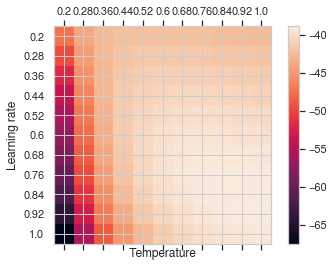

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel("Learning rate")
ax.set_xlabel("Temperature")
plt.show()

## Optimizing Procedural Log-Likelihood Using Machine Learning

Instead of using grid search, we can use standard optimization procedures for identifying the best set of parameters for each participant. First, we need to create a vectorized version of the `LLproc` procedure:

In [88]:
def vLLproc(array):
    """Vector function of procedural log-likelihood"""
    global data
    alpha, temp = array
    return -1 * LLproc(data, alpha, temp)

And, then, we just apply the Nelder-Mead algorithm from the `scipy.optimize` package:

In [89]:
opt.minimize(vLLproc, x0 = [0.5, 0.5], method = "Nelder-Mead")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 38.89126390332925
             x: [ 8.414e-01  9.108e-01]
           nit: 35
          nfev: 70
 final_simplex: (array([[ 8.414e-01,  9.108e-01],
                       [ 8.414e-01,  9.108e-01],
                       [ 8.415e-01,  9.109e-01]]), array([ 3.889e+01,  3.889e+01,  3.889e+01]))

# Log-Likelihood for a Declarative Model

We can do the the same for ta declarative model.  As before, we can create a declarative LL function based on ACT-R. First, we need to create an _activation_ function, which would predict the activation of a memory given its history of usage, the time at which activation is computed, and the decay rate. According to ACT-R, a memory's activation $A(t)$ is the logarithm of its decaying traces:

$ A(t) = \log \sum_i (t - t_i)^d$

In [90]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

This is a normal activation function that gives us decay over time:

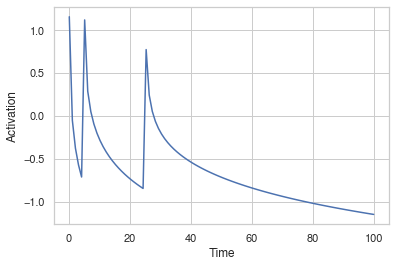

In [91]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Now let's create a log-likelihood function for the declarative model: For very choice made by the participant, the function computes the probability of retrieving a success associated with that choice, then updates the cumulative log-likelihood and, if the decision was successful, adds another trace to memory

In [92]:
def LLdecl(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    DM = dict(zip(choices, [[0.001] for x in choices]))
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        prob = boltzmann(options, values, temp)[response]
        
        # Sum up the LLs
        LL += np.log(max(prob, 10e-10))
        # If we have a positive feedback, add a trace
        if rewards[feedback] > 0:
            DM[response] += [time]
        
        if trial % 8 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        # Skip a week between sessions
        if trial % 32 == 0:
            time += (7 * 24 * 60 * 60)
        
        trial += 1
        
    return LL

Simple test with subject data

In [93]:
LLdecl(data, 0.5, 1)

-46.30663225792138

Let's visualize the log-likelihood space

/tmp/ipykernel_91373/2575681153.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
/tmp/ipykernel_91373/2575681153.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])


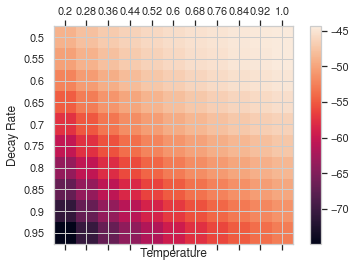

In [94]:
decayspace = np.linspace(0.1, 1, 10)
tempspace = np.linspace(0.5, 1, 11)
matrix = np.zeros((len(decayspace), len(tempspace)))
for i, d in enumerate(decayspace):
    for j, t in enumerate(tempspace):
        matrix[i,j] = LLdecl(data, d, t)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in alphaspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel("Decay Rate")
ax.set_xlabel("Temperature")
plt.show()

## Optimization of Declarative Memory Model

As usual, first we start by creating a vector function 

In [95]:
def vLLdecl(array):
    """Vector function of data"""
    global data
    decay, temp = array
    return -1*LLdecl(data, decay, temp)

And then, we optimize

In [96]:
opt.minimize(vLLdecl, x0 = [0.2, 1], method = "Nelder-Mead")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 43.2138883059402
             x: [ 3.361e+00  1.885e+01]
           nit: 65
          nfev: 123
 final_simplex: (array([[ 3.361e+00,  1.885e+01],
                       [ 3.360e+00,  1.885e+01],
                       [ 3.361e+00,  1.885e+01]]), array([ 4.321e+01,  4.321e+01,  4.321e+01]))

# Assign all Subjects

We can now loop over all of Cher's participants (_N_=199) and compute the best parameters and high log-liklihoods of each model for each participant.  

In [97]:
DO_ALL = False
dataframe = []

if DO_ALL:
    folder = [x for x in os.listdir("subject_data") if x.endswith("_fnca")] 
    for folder in tqdm(folders): 
        data = pd.read_csv("subject_data/" + folder + "/subject.csv")
        alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
        llproc = LLproc(data, alpha, ptemp)
            
        decay, dtemp = opt.minimize(vLLdecl, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
        lldecl = LLdecl(data, decay, dtemp)
            
        best = "Declarative"
        if llproc > lldecl:
            best = "Procedural"
            
        diff = llproc - lldecl
            
        row = [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]
            
        dataframe += [row]

    result = pd.DataFrame(dataframe, columns=["HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

Here are the results

In [98]:
if DO_ALL:
    result.to_csv("LL_model1.csv")
else:
    result = pd.read_csv("LL_model1.csv")
result

,Unnamed: 0,HCPID,alpha,proc.temp,proc.LL,decay,decl.temp,decl.LL,best.model,diff.LL
0,0,173132_fnca,0.451225,0.776263,-34.927074,0.010000,1.557214,-36.702023,Procedural,1.774949
1,1,161731_fnca,0.010047,2.000000,-38.845312,0.010014,2.000000,-39.802325,Procedural,0.957012
2,2,150523_fnca,0.574210,0.542022,-15.386656,1.064539,1.999999,-17.645053,Procedural,2.258397
3,3,173940_fnca,1.355398,1.999959,-38.188769,0.275263,1.999996,-38.838913,Procedural,0.650144
4,4,169343_fnca,0.029958,0.341148,-37.853046,0.072103,2.000000,-38.654348,Procedural,0.801302
...,...,...,...,...,...,...,...,...,...,...
194,194,147737_fnca,0.105373,1.027211,-37.960643,0.010036,2.000000,-38.529948,Procedural,0.569305
195,195,127933_fnca,1.136093,2.000000,-38.857494,0.010010,2.000000,-42.634872,Procedural,3.777379
196,196,122620_fnca,0.397623,1.554124,-37.947207,0.049015,2.000000,-38.608287,Procedural,0.661081
197,197,146331_fnca,0.010038,2.000000,-38.862449,0.010013,2.000000,-39.667132,Procedural,0.804683


Visualize the distribution LL differences and the number of Declarative / Procedural participants identified by the models

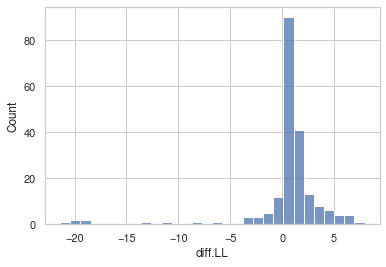

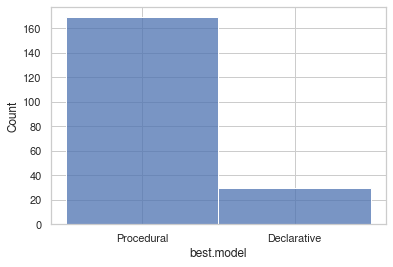

In [99]:
sns.histplot(result, x="diff.LL", bins=30)
plt.show()
sns.histplot(result, x="best.model")
plt.show()

Let's visualize the parameters of the procedural model


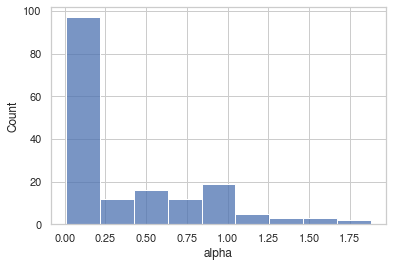

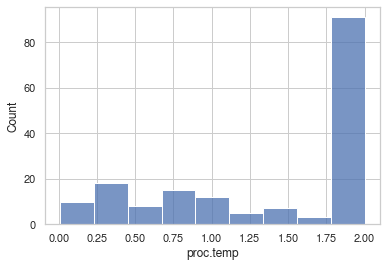

In [100]:
procedural = result[result['best.model'] == "Procedural"]
sns.histplot(procedural, x="alpha")
plt.show()
sns.histplot(procedural, x="proc.temp")
plt.show()

And now, the declarative models

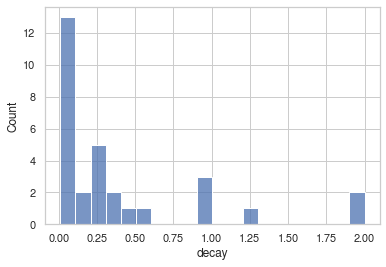

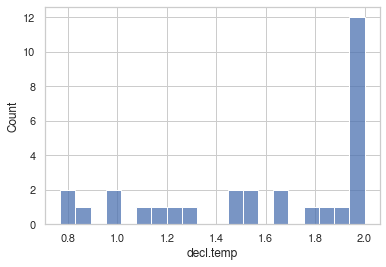

In [101]:
declarative = result[result['best.model'] == "Declarative"]
sns.histplot(declarative, x="decay", bins=20)
plt.show()
sns.histplot(declarative, x="decl.temp", bins=20)
plt.show()

# Alternative Version of Log-Likelihood for a Declarative Model

In this version, there are two routes to make a decision: To remember something that worked and to remember something that did _not_. The total probability of a choice $c$ is given by the probability of retrieving two possible memories, one that associates $c$ with reward $+1$ and one that associates the other choice $-c$ with punishment $-0.5$: 

$P(c) = P(c, 1) + P(\neg c, -0.5)$

In [102]:
def LLdecl2(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    choices = list(set(data.CurrentResponse))
    outcomes = [rewards[x] for x in rewards.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.001] for x in memories]))
    
    LL = 0.0
    time = 15
    trial = 1
    step = 3.5
    
    for response, feedback in zip(data.CurrentResponse, data.TrialType):
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        probs = boltzmann(options, values, temp)
        
        # The probability of picking option X is the probability of retrieving a success for X 
        # plus the probability of retrieving a punishment for Y.
        prob1 = probs["%s-%s" % (response, 1.0)]
        other = [x for x in choices if x != response]
        prob2 = probs["%s-%s" % (other[0], -0.5)]
        
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
        # If we have a non-neutral feedback, add a trace
        if rewards[feedback] != 0:
            DM["%s-%s" % (response, rewards[feedback])] += [time]
        
        if trial % 8 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 32 == 0:
            time += (7 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return LL

def vLLdecl2(array):
    """Vector function of data"""
    global data
    decay, temp = array
    return -1 * LLdecl2(data, decay, temp)

## Assign all Subjects (Second version)

Let's do the analysis again, using the new Declarative model and Nussembaum's procedure to 

In [103]:
DO_ALL_AGAIN = False
dataframe = []

if DO_ALL_AGAIN:
    folders = [x for x in os.listdir("subject_data") if x.endswith("_fnca")]
    for folder in tqdm(folders):
        data = pd.read_csv("subject_data/" + folder + "/subject.csv")
        alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
        llproc = LLproc(data, alpha, ptemp)
            
        decay, dtemp = opt.minimize(vLLdecl2, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
        lldecl = LLdecl2(data, decay, dtemp)
            
        best = "Declarative"
        if llproc > lldecl:
            best = "Procedural"
            
        diff = llproc - lldecl
            
        row = [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]
            
        dataframe += [row]

    result2 = pd.DataFrame(dataframe, columns=["HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

And let's save and visualize the results

In [104]:
if DO_ALL_AGAIN:
    result2.to_csv("LL_model2.csv")
else:
    result2 = pd.read_csv("LL_model2.csv")
result2

,Unnamed: 0,HCPID,alpha,proc.temp,proc.LL,decay,decl.temp,decl.LL,best.model,diff.LL
0,0,173132_fnca,0.451225,0.776263,-34.927074,0.327085,1.806428,-36.725845,Procedural,1.798771
1,1,161731_fnca,0.010047,2.000000,-38.845312,0.010008,2.000000,-39.222133,Procedural,0.376820
2,2,150523_fnca,0.574210,0.542022,-15.386656,0.010000,0.268588,-16.101302,Procedural,0.714645
3,3,173940_fnca,1.355398,1.999959,-38.188769,0.365819,1.999997,-38.208844,Procedural,0.020075
4,4,169343_fnca,0.029958,0.341148,-37.853046,0.010048,0.505340,-35.779181,Declarative,-2.073865
...,...,...,...,...,...,...,...,...,...,...
194,194,147737_fnca,0.105373,1.027211,-37.960643,0.581204,2.000000,-37.847621,Declarative,-0.113022
195,195,127933_fnca,1.136093,2.000000,-38.857494,0.010017,2.000000,-41.835989,Procedural,2.978495
196,196,122620_fnca,0.397623,1.554124,-37.947207,0.010000,1.999994,-39.178806,Procedural,1.231599
197,197,146331_fnca,0.010038,2.000000,-38.862449,0.010014,2.000000,-39.440798,Procedural,0.578349


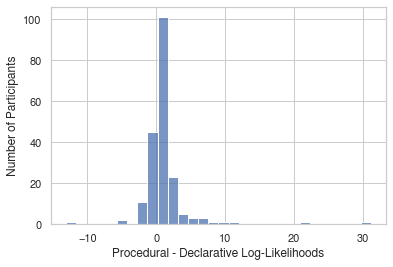

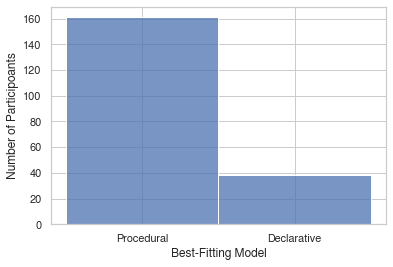

In [105]:
result2.value_counts("best.model")
sns.histplot(result2, x="diff.LL", bins=30)
plt.xlabel("Procedural - Declarative Log-Likelihoods")
plt.ylabel("Number of Participants")
plt.show()

ax = sns.histplot(result2, x="best.model")
ax.set_xlabel("Best-Fitting Model")
ax.set_ylabel("Number of Participoants")
plt.show()

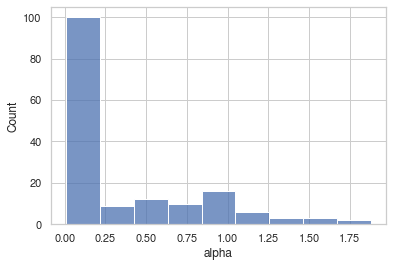

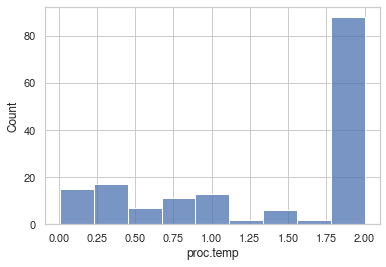

In [106]:
procedural = result2[result2['best.model'] == "Procedural"]
sns.histplot(procedural, x="alpha")
plt.show()
sns.histplot(procedural, x="proc.temp")
plt.show()

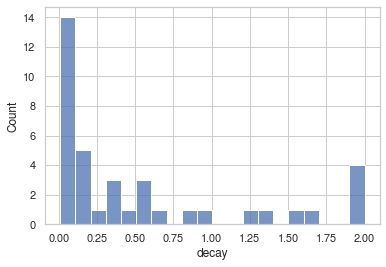

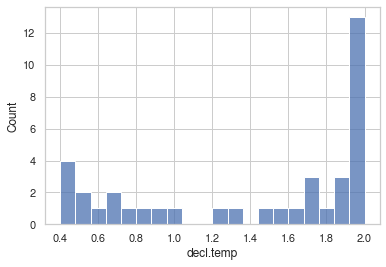

In [107]:
declarative = result2[result2['best.model'] == "Declarative"]
sns.histplot(declarative, x="decay", bins=20)
plt.show()
sns.histplot(declarative, x="decl.temp", bins=20)
plt.show()

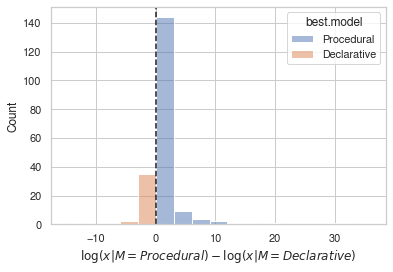

In [108]:
sns.histplot(result2, x="diff.LL", hue="best.model", binwidth=3, binrange=[-15, 36])
plt.xlabel("$\log(x|M=Procedural) - \log(x|M=Declarative)$") 
plt.axvline(x=0, linestyle="dashed", color="k")
plt.show()

# How Reliable Are the Assignments? Model Recovery

Here we can attempt model recovery. To do so, we need a way to "forward model" (that is, simulate) the data. First, we need a function to turn the Boltzmann probabilities into actual decisions 

In [109]:
def policy(bprobs):
    """Selects an action based on a distribution of probabilities"""
    options = list(bprobs.keys())
    probs = [bprobs[opt] for opt in options]
    return np.random.choice(options, p=probs)

We can now create two functions to simulate the data, one for the Procedural and one of the Declarative model:

In [110]:
def simulate_data_proc(data, alpha, temp):
    """Produces a series of choices based on the experiences of a single participant"""
    choices = list(set(data.CurrentResponse))
    Q = dict(zip(choices, [0 for x in choices]))
    dataframe = []
    for feedback in data.TrialType:
        options = Q.keys()
        values = [Q[opt] for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        response = policy(boltz_probs)
        
        dataframe += [[response, feedback]]
        
        Q_old = Q[response]
        reward = rewards[feedback]
        Q[response] = Q_old + alpha * (reward - Q_old)
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])


def simulate_data_decl(data, decay, temp):
    """Produces a series of choices based on the experiences of a single participant"""
    choices = list(set(data.CurrentResponse))
    DM = dict(zip(choices, [[0.001] for x in choices]))
    time = 15
    trial = 1
    step = 3.5
    dataframe = []
    for feedback in data.TrialType:
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        response = policy(boltz_probs)
        
        dataframe += [[response, feedback]]
        
        if rewards[feedback] > 0:
            DM[response] += [time]
        
        if trial % 7 == 0:
            time += 15  # Fixation block
        
        else:
            time += step # onset of next trial
            
        # Skip a week between sessions
        if trial % 28 == 0:
            time += (7 * 24 * 60 * 60)
        
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])
        

And now, a forward function for the second Declarative model.

In [111]:
def simulate_data_decl2(data, decay, temp):
    choices = list(set(data.CurrentResponse))
    outcomes = [rewards[x] for x in rewards.keys() if x != "Neutral"]
    memories = ["%s-%s" % (choice, outcome) for choice in choices for outcome in outcomes]
    DM = dict(zip(memories, [[0.1] for x in memories]))    
    
    time = 15
    trial = 1
    step = 3.5
    
    dataframe = []
    
    for feedback in data.TrialType:
        # Calculate log likelihood of response
        options = DM.keys()
        values = [activation(DM[opt], time, decay) for opt in options]
        boltz_probs = boltzmann(options, values, temp)
        
        memory = policy(boltz_probs)
        response = float(memory[0:3]) # Turn first three chars into a float number
        
        if float(memory[4:]) < 0:
            other = [x for x in choices if x != response]
            response = other[0]
        
        dataframe += [[response, feedback]]
        
        if rewards[feedback] != 0:
            DM["%s-%s" % (response, rewards[feedback])] += [time]
        
        if trial % 7 == 0:
            time += 15  # Fixation block
        else:
            time += step # onset of next trial
            
        
        if trial % 28 == 0:
            time += (7 * 24 * 60 * 60) # Add a week between sessions.
        
        trial += 1
        
    return pd.DataFrame(dataframe, columns=["CurrentResponse", "TrialType"])


Quick test

In [112]:
k = simulate_data_decl(data, 0.5, 1)
data = k
opt.minimize(vLLdecl, x0 = [0.5, 0.5], bounds=[[0,2],[0, 5]], method = "Powell")

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.764496621157626
       x: [ 9.868e-10  1.220e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-1.744e-05  2.511e-05]]
    nfev: 117

And now, two functions for model recovery: the first one based on the first Declarative model

In [113]:
def model_recovery(simdata):
    """Comparative fit of model"""
    alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 5]]).x
    llproc = LLproc(data, alpha, ptemp)
            
    decay, dtemp = opt.minimize(vLLdecl, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 5]]).x
    lldecl = LLdecl(data, decay, dtemp)
            
    best = "Declarative"
    if llproc > lldecl:
        best = "Procedural"
            
    diff = llproc - lldecl
            
    return [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]

And one based on Declarative 2:

In [114]:
def model_recovery2(simdata):
    """Comparative fit of model"""
    alpha, ptemp = opt.minimize(vLLproc, x0 = [0.1, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
    llproc = LLproc(data, alpha, ptemp)
            
    decay, dtemp = opt.minimize(vLLdecl2, x0 = [0.5, 1], method = "Powell", bounds=[[0.01, 2], [0, 2]]).x
    lldecl = LLdecl2(data, decay, dtemp)
            
    best = "Declarative"
    if llproc > lldecl:
        best = "Procedural"
            
    diff = llproc - lldecl
            
    return [folder, alpha, ptemp, llproc, decay, dtemp, lldecl, best, diff]

## Model Recovery (Declarative model 1)


In [115]:
DO_RECOVERY = True
recovery_df = []

if DO_RECOVERY:
    global data
    folders = [x for x in os.listdir("subject_data") if x.endswith("_fnca")]
    for folder in tqdm(folders, desc='Participants'):
        subj_data = pd.read_csv("subject_data/" + folder + "/subject.csv")
        for model in ["Procedural", "Declarative"]:
            alpha = np.nan
            ptemp = np.nan
            decay = np.nan
            dtemp = np.nan
            results = []
            #for run in tqdm(range(20), desc='Simulations', leave=False):
            for run in range(20):
                if model == "Procedural":
                    alpha = np.random.uniform(0.01, 2)
                    ptemp = np.random.uniform(0, 2)
                        
                    simdata = simulate_data_proc(subj_data, alpha, ptemp)
                    data = simdata
                    results = model_recovery(simdata)
                    
                else:
                    decay = np.random.uniform(0.01, 2)
                    dtemp = np.random.uniform(0, 2)
                        
                    simdata = simulate_data_decl2(subj_data, decay, dtemp)
                    data = simdata
                    results = model_recovery(simdata)
                            
                row = [model, alpha, ptemp, decay, dtemp] + results
                recovery_df += [row]

#recovery_df = pd.DataFrame(recovery_df, columns=dataframe, columns=["orig.model", "orig.alpha", "orig.proc.temp", "orig.decay", "orig.decl.temp",
 #                                                                   "HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

            

FileNotFoundError: [Errno 2] No such file or directory: 'subject_data'

In [ ]:
if DO_RECOVERY:
    recovery_df = pd.DataFrame(recovery_df, columns=["orig.model", "orig.alpha", "orig.proc.temp", "orig.decay", "orig.decl.temp", 
                                                     "HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    
    recovery_df.to_csv("model_recovery_new1.csv")
else:
    recovery_df = pd.read_csv("model_recovery_new1.csv")
recovery_df

In [ ]:
confusion_matrix = pd.crosstab(recovery_df['orig.model'], recovery_df['best.model'], rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(confusion_matrix/(199*20), annot=True, fmt=".2f")
plt.show()

## Model Recovery (Declarative model 2)

In [ ]:
DO_RECOVERY2 = False
recovery_df = []

if DO_RECOVERY2:
    global data
    folders = [x for x in os.listdir("subject_data") if x.endswith("_fnca")]
    for folder in tqdm(folders, desc='Participants'):
        subj_data = pd.read_csv("subject_data/" + folder + "/subject.csv")
        for model in ["Procedural", "Declarative"]:
            alpha = np.nan
            ptemp = np.nan
            decay = np.nan
            dtemp = np.nan
            results = []
            #for run in tqdm(range(20), desc='Simulations', leave=False):
            for run in range(20):
                if model == "Procedural":
                    alpha = np.random.uniform(0.01, 2)
                    ptemp = np.random.uniform(0, 2)
                        
                    simdata = simulate_data_proc(subj_data, alpha, ptemp)
                    data = simdata
                    results = model_recovery2(simdata)
                    
                else:
                    decay = np.random.uniform(0.01, 2)
                    dtemp = np.random.uniform(0, 2)
                        
                    simdata = simulate_data_decl2(subj_data, decay, dtemp)
                    data = simdata
                    results = model_recovery2(simdata)
                            
                row = [model, alpha, ptemp, decay, dtemp] + results
                recovery_df += [row]

#recovery_df = pd.DataFrame(recovery_df, columns=dataframe, columns=["orig.model", "orig.alpha", "orig.proc.temp", "orig.decay", "orig.decl.temp",
 #                                                                   "HCPID", "alpha", "proc.temp", "proc.LL", "decay", "decl.temp", "decl.LL", "best.model", "diff.LL"])    

            

In [ ]:
if DO_RECOVERY2:
    recovery_df = pd.DataFrame(recovery_df, columns=["orig.model", 
                                                     "orig.alpha", "orig.proc.temp", 
                                                     "orig.decay", "orig.decl.temp", 
                                                     "HCPID", 
                                                     "alpha", "proc.temp", "proc.LL", 
                                                     "decay", "decl.temp", "decl.LL", 
                                                     "best.model", "diff.LL"])    
    recovery_df.to_csv("model_recovery_new2.csv")
else:
    recovery_df = pd.read_csv("model_recovery_new2.csv")
recovery_df

In [ ]:
confusion_matrix = pd.crosstab(recovery_df['orig.model'], recovery_df['best.model'], rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(confusion_matrix/(199*20), annot=True, fmt=".1%")
plt.title("Recovery Probabilities by Model")
plt.show()

In [ ]:
proc = recovery_df[recovery_df['orig.model']=="Procedural"]
decl = recovery_df[recovery_df['orig.model']=="Declarative"]

In [ ]:
sns.regplot(data=proc, x="orig.alpha", y="alpha", scatter_kws={"alpha":0.1}, fit_reg=True)
plt.show()
sns.regplot(data=proc, x="orig.proc.temp", y="proc.temp", scatter_kws={"alpha":0.1}, fit_reg=True)
plt.show()

In [ ]:
sns.lmplot(data=decl, x="orig.decay", y="decay", scatter_kws={"alpha":0.1}, fit_reg=True)
plt.show()
sns.lmplot(data=decl, x="orig.decl.temp", y="decl.temp", scatter_kws={"alpha":0.1}, fit_reg=True)
plt.show()

### Analysis by Subject

In [ ]:
recovery_df['recovery.acc'] = np.where(recovery_df['orig.model'] == recovery_df['best.model'], 1, 0)
agg=recovery_df.groupby(['HCPID', 'orig.model']).mean()

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=agg, ax=ax, x="HCPID", y="recovery.acc", hue="orig.model")
plt.show()

### Analysis by Parameter

In [ ]:
sns.regplot(data=agg, x="orig.proc.temp", y="recovery.acc")
plt.show()
sns.regplot(data=agg, x="orig.decl.temp", y="recovery.acc")
plt.show()

In [ ]:
recovery_df.corr()

In [ ]:
np.log(0.5)*56

In [ ]:
result2 =  result2.assign(maxLL=lambda x: max(x['proc.LL'], x['decl.LL']))

In [ ]:
result2 = pd.read_csv("LL_model2.csv")
result2